In [ ]:
## !pip install datasets
## !pip install python-dotenv
##المكتبات

In [ ]:
from dotenv import load_dotenv
import os
from huggingface_hub import login

load_dotenv()
#هنا سجلنا  في الموقع
huggingface_T = os.getenv("huggingface_T")
login(token=huggingface_T)

In [66]:
from datasets import load_dataset

dataset = load_dataset("KFUPM-JRCAI/arabic-generated-abstracts")
# سوينا لود للداتا سيت
print(dataset)


DatasetDict({
    by_polishing: Dataset({
        features: ['original_abstract', 'allam_generated_abstract', 'jais_generated_abstract', 'llama_generated_abstract', 'openai_generated_abstract'],
        num_rows: 2851
    })
    from_title: Dataset({
        features: ['original_abstract', 'allam_generated_abstract', 'jais_generated_abstract', 'llama_generated_abstract', 'openai_generated_abstract'],
        num_rows: 2963
    })
    from_title_and_content: Dataset({
        features: ['original_abstract', 'allam_generated_abstract', 'jais_generated_abstract', 'llama_generated_abstract', 'openai_generated_abstract'],
        num_rows: 2574
    })
})


In [ ]:
def process_split(split, split_name):
    """
    Convert one split into a unified dataframe with labels
    """
    data = []

    # Human abstracts
    for text in split["original_abstract"]:
        data.append({
            "text": text,
            "label": 0,               # 0 = Human
            "generated_by": "human",
            "source_split": split_name
        })

    # AI abstracts
    ai_sources = {
        "allam": split["allam_generated_abstract"],
        "jais": split["jais_generated_abstract"],
        "llama": split["llama_generated_abstract"],
        "openai": split["openai_generated_abstract"],
    }

    for model, texts in ai_sources.items():
        for text in texts:
            data.append({
                "text": text,
                "label": 1,           # 1 = AI
                "generated_by": model,
                "source_split": split_name
            })

    return pd.DataFrame(data)

In [ ]:
import pandas as pd
#Process all splits
df_by_polishing = process_split(dataset["by_polishing"], "by_polishing")
df_from_title = process_split(dataset["from_title"], "from_title")
df_from_title_and_content = process_split(
    dataset["from_title_and_content"],
    "from_title_and_content"
)


In [ ]:
#Merge all splits
final_df = pd.concat(
    [df_by_polishing, df_from_title, df_from_title_and_content],
    ignore_index=True
)

In [ ]:
final_df.head(5)

,text,label,generated_by,source_split
0,كثيرا ما ارتبطت المصادر التاريخية في الأندلس خ...,0,human,by_polishing
1,يعد العامل الثقافي احد ابرز الاسباب التي يعزى ...,0,human,by_polishing
2,شكلت تلك الجهود والمساعي الرائدة التي قام بها ...,0,human,by_polishing
3,يقوم المقال على اشكالية الضرائب الغير شرعية في...,0,human,by_polishing
4,تتفق المصادر التاريخية المتوفرة حول موضوع تطور...,0,human,by_polishing


In [69]:
import os

os.makedirs("data/raw", exist_ok=True)

final_df.to_excel(
    "data/raw/all_raw_data.xlsx",
    index=False
)

print("Raw data saved as XLSX")



Raw data saved as XLSX


In [ ]:
df = final_df.copy()

print("Missing values per column:")
print(df.isnull().sum())
print("--------------------------------------------------------")

# عدد الصفوف المكررة بالكامل
print("Number of duplicate rows:", df.duplicated().sum())
print("--------------------------------------------------------")

# عدد القيم المكررة في كل عمود
for col in df.columns:
    print(f"Duplicates in column '{col}': {df[col].duplicated().sum()}")
print("--------------------------------------------------------")

# عدد القيم الفارغة أو التي تحتوي مسافات فقط (مهم للنصوص)
for col in df.columns:
    if df[col].dtype == "object":
        empty_count = df[col].apply(
            lambda x: isinstance(x, str) and x.strip() == ""
        ).sum()
        print(f"Blank or space-only values in column '{col}': {empty_count}")
    else:
        print(f"Blank or space-only values in column '{col}': Not applicable")

print("--------------------------------------------------------")
print("First phase ends here")

Missing values per column:
text            0
label           0
generated_by    0
source_split    0
dtype: int64
--------------------------------------------------------
Number of duplicate rows: 3
--------------------------------------------------------
Duplicates in column 'text': 5415
Duplicates in column 'label': 41938
Duplicates in column 'generated_by': 41935
Duplicates in column 'source_split': 41937
--------------------------------------------------------
Blank or space-only values in column 'text': 0
Blank or space-only values in column 'label': Not applicable
Blank or space-only values in column 'generated_by': 0
Blank or space-only values in column 'source_split': 0
--------------------------------------------------------
First phase ends here


In [ ]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from datasets import load_dataset
#مكتبات نحتاجها لي البريبروسيسنق

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def remove_diacritics(text):
    diacritics = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    return re.sub(diacritics, '', text)

def normalize(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("[^؀-ۿ ]+", " ", text)
    return text

stop_words = set(stopwords.words("arabic"))
stemmer = ISRIStemmer()

def preprocess_text(text):
    text = str(text)
    text = remove_diacritics(text)
    text = normalize(text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [stemmer.stem(w) for w in tokens]
    return " ".join(tokens)

In [ ]:
df = final_df.copy()

df["clean_text"] = df["text"].apply(preprocess_text)

print("Preprocessing completed")
print(df.columns)
df.head(2)

Preprocessing completed
Index(['text', 'label', 'generated_by', 'source_split', 'clean_text'], dtype='object')


,text,label,generated_by,source_split,clean_text
0,كثيرا ما ارتبطت المصادر التاريخية في الأندلس خ...,0,human,by_polishing,ربط صدر ارخ دلس خصه كتب رجم هرس رمج وغر درس حي...
1,يعد العامل الثقافي احد ابرز الاسباب التي يعزى ...,0,human,by_polishing,يعد عمل ثقف احد برز سبب يعز سقط دول وحد ، حتي ...


In [71]:
import os

os.makedirs("data/processed", exist_ok=True)

clean_df.to_excel(
    "data/processed/all_clean_data.xlsx",
    index=False
)

print("Clean data saved as Excel (.xlsx) successfully!")


Clean data saved as Excel (.xlsx) successfully!


In [ ]:
Human_Texts = df[df["label"] == 0]["clean_text"].dropna().tolist()
AI_Texts = df[df["label"] == 1]["clean_text"].dropna().tolist()

In [ ]:
import numpy as np

def text_stats(texts):
    words = [w for txt in texts for w in txt.split()]
    avg_word_len = np.mean([len(w) for w in words])
    avg_sent_len = np.mean([len(txt.split()) for txt in texts])
    vocab = set(words)
    CD = len(vocab) / len(words)
    return avg_word_len, avg_sent_len, CD

stats_human = text_stats(Human_Texts)
stats_ai = text_stats(AI_Texts)

print("\nStatistical Summary:")
print(f"Human: Avg word len={stats_human[0]:.2f}, "
      f"Avg sent len={stats_human[1]:.2f}, CD={stats_human[2]:.3f}")

print(f"AI: Avg word len={stats_ai[0]:.2f}, "
      f"Avg sent len={stats_ai[1]:.2f}, CD={stats_ai[2]:.3f}")


Statistical Summary:
Human: Avg word len=3.29, Avg sent len=98.16, CD=0.019
AI: Avg word len=3.27, Avg sent len=86.22, CD=0.007


In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer

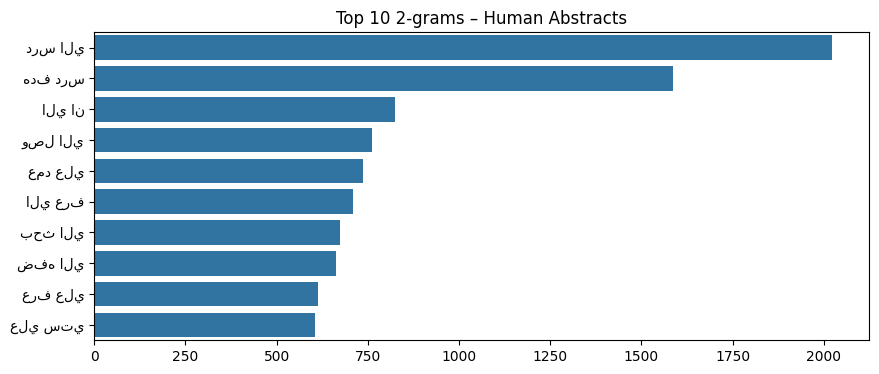

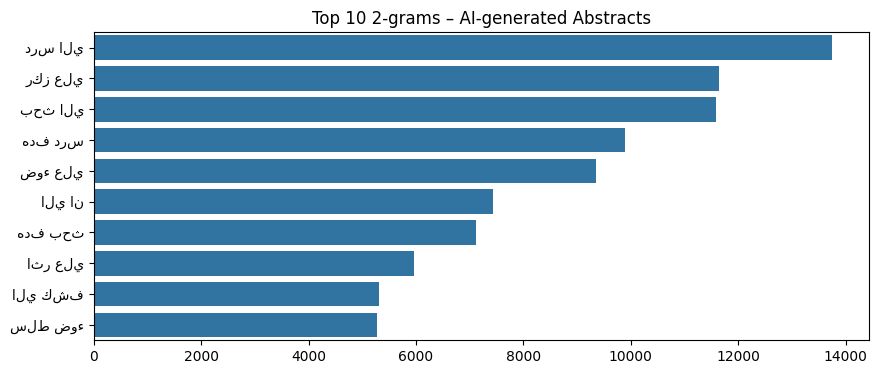

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams(texts, label_name, n=2, top_k=10):
    vec = CountVectorizer(ngram_range=(n, n))
    bag = vec.fit_transform(texts)
    sum_words = bag.sum(axis=0)
    freqs = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    freqs = sorted(freqs, key=lambda x: x[1], reverse=True)[:top_k]

    words, counts = zip(*freqs)
    plt.figure(figsize=(10,4))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f"Top {top_k} {n}-grams – {label_name}")
    plt.show()

plot_top_ngrams(Human_Texts, "Human Abstracts", n=2)
plot_top_ngrams(AI_Texts, "AI-generated Abstracts", n=2)

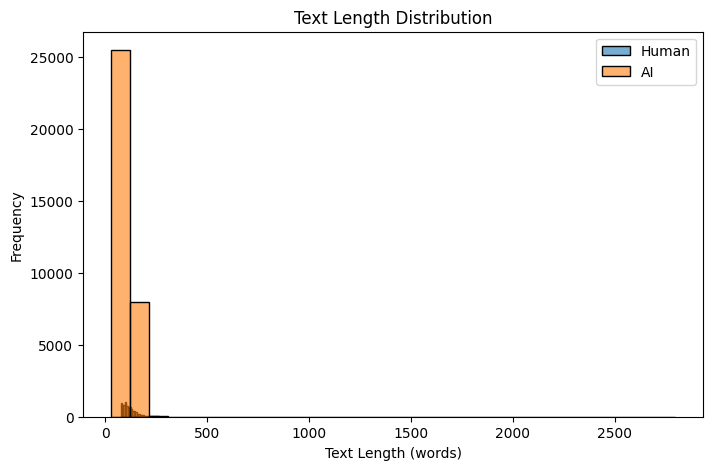

In [ ]:
df["text_length"] = df["text"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8,5))
sns.histplot(df[df["label"]==0]["text_length"], bins=30, label="Human", alpha=0.6)
sns.histplot(df[df["label"]==1]["text_length"], bins=30, label="AI", alpha=0.6)
plt.xlabel("Text Length (words)")
plt.ylabel("Frequency")
plt.title("Text Length Distribution")
plt.legend()
plt.show()

/tmp/ipython-input-3311962599.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


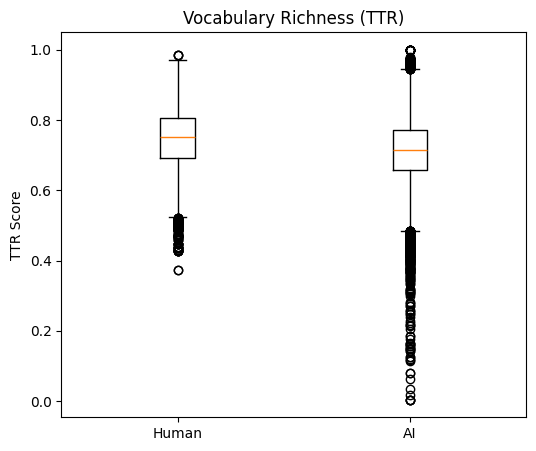

In [ ]:
def type_token_ratio(text):
    words = text.split()
    return len(set(words)) / len(words) if words else 0

df["TTR"] = df["clean_text"].apply(type_token_ratio)

plt.figure(figsize=(6,5))
plt.boxplot(
    [df[df["label"]==0]["TTR"], df[df["label"]==1]["TTR"]],
    labels=["Human", "AI"]
)
plt.title("Vocabulary Richness (TTR)")
plt.ylabel("TTR Score")
plt.show()

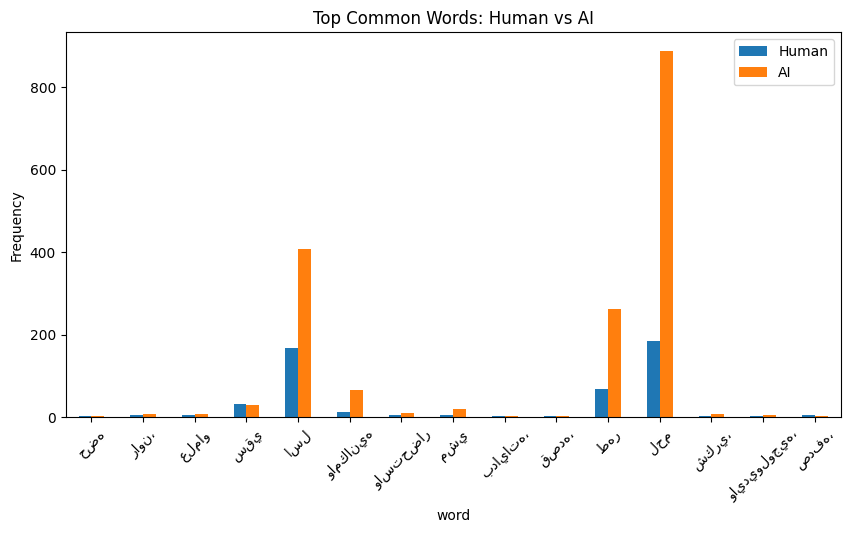

In [ ]:
from collections import Counter

Human_words = " ".join(df[df["label"]==0]["clean_text"]).split()
AI_words = " ".join(df[df["label"]==1]["clean_text"]).split()

Human_freq = Counter(Human_words)
AI_freq = Counter(AI_words)

common_words = set(Human_freq.keys()) & set(AI_freq.keys())

data = [(w, Human_freq[w], AI_freq[w]) for w in list(common_words)[:15]]

freq_df = pd.DataFrame(data, columns=["word", "Human", "AI"])

freq_df.plot(
    x="word", kind="bar", figsize=(10,5),
    title="Top Common Words: Human vs AI", rot=45
)
plt.ylabel("Frequency")
plt.show()


In [ ]:
import re
import math
import numpy as np
import pandas as pd
import unicodedata
from collections import Counter
from datasets import load_dataset
import regex as re2

In [ ]:
#Helper functions


def simple_word_tokenize(text):
    """
    Tokenize text into words / symbols with Arabic support.
    """
    return re2.findall(r"\p{Arabic}+|\w+|[^\s\w]", text, flags=re2.VERSION1)

def sentence_tokenize(text):
    """
    Split text into sentences using Arabic/English punctuation.
    """
    if not isinstance(text, str):
        return []
    parts = re.split(r'(?<=[\.\?\!\u061F\u061B])\s+', text)
    return [p.strip() for p in parts if p.strip()]

def paragraph_tokenize(text):
    """
    Split text into paragraphs based on double newlines.
    """
    if not isinstance(text, str):
        return []
    paragraphs = re.split(r'\s*\n\s*\n\s*|\s*\r\n\s*\r\n\s*', text.strip())
    return [p.strip() for p in paragraphs if p.strip()]


In [ ]:
# Column names to use
original_text_columns = "text"
clean_text_columns = "clean_text"


#  Tokens  تستخرج من النص clean

df["tokens"] = df[clean_text_columns].apply(
    lambda t: [tok for tok in simple_word_tokenize(t) if tok.strip()] if isinstance(t, str) else []
)


# Words تستخرج من النص clean

df["words"] = df["tokens"].apply(
    lambda toks: [tok for tok in toks if re.search(r'\w', tok)]
)


# Sentences تستخرج من النص الاصلي

df["sentences"] = df[original_text_columns].apply(
    lambda t: sentence_tokenize(t)
)


#  Paragraphs تستخرج من النص الاصلي

df["paragraphs"] = df[original_text_columns].apply(
    lambda t: paragraph_tokenize(t)
)

print("Feature engineering completed! Columns now:")
print(df.columns)
df.head(2)


Feature engineering completed! Columns now:
Index(['text', 'label', 'generated_by', 'source_split', 'clean_text',
       'text_length', 'TTR', 'tokens', 'words', 'sentences', 'paragraphs'],
      dtype='object')


,text,label,generated_by,source_split,clean_text,text_length,TTR,tokens,words,sentences,paragraphs
0,كثيرا ما ارتبطت المصادر التاريخية في الأندلس خ...,0,human,by_polishing,ربط صدر ارخ دلس خصه كتب رجم هرس رمج وغر درس حي...,119,0.717172,"[ربط, صدر, ارخ, دلس, خصه, كتب, رجم, هرس, رمج, ...","[ربط, صدر, ارخ, دلس, خصه, كتب, رجم, هرس, رمج, ...",[كثيرا ما ارتبطت المصادر التاريخية في الأندلس ...,[كثيرا ما ارتبطت المصادر التاريخية في الأندلس ...
1,يعد العامل الثقافي احد ابرز الاسباب التي يعزى ...,0,human,by_polishing,يعد عمل ثقف احد برز سبب يعز سقط دول وحد ، حتي ...,143,0.763636,"[يعد, عمل, ثقف, احد, برز, سبب, يعز, سقط, دول, ...","[يعد, عمل, ثقف, احد, برز, سبب, يعز, سقط, دول, ...",[يعد العامل الثقافي احد ابرز الاسباب التي يعزى...,[يعد العامل الثقافي احد ابرز الاسباب التي يعزى...


In [ ]:
# Feature 14: Hapax dislegomena Ratio-يعطي مؤشرًا على تكرار الكلمات النادرة.
feature_name = f'{clean_text_columns}_f014_hapax_dislegomena_ratio'

def _hapax_dislegomena_ratio(words):
    """Calculates Hapax Dislegomena Ratio (V2/N)."""
    N = len(words)
    if N == 0:
        return 0.0

    c = Counter([w.lower() for w in words])
    # V2 is the number of words that appear exactly twice
    V2 = sum(1 for v in c.values() if v == 2)

    return float(V2) / N

df[feature_name] = df["words"].apply(_hapax_dislegomena_ratio)

In [ ]:
# 35. Total number of paragraphs (P)
df['f035_Total_number_of_paragraphs_(P)'] = df["paragraphs"].apply(len)

In [ ]:
# (37) Average number of words /P
df['f037_Average_words_per_paragraph'] = df.apply(
    lambda row: len(row['words']) / row['f035_Total_number_of_paragraphs_(P)']
    if row['f035_Total_number_of_paragraphs_(P)'] > 0 else 0,
    axis=1
)

In [ ]:
df.head(5)

,text,label,generated_by,source_split,clean_text,text_length,TTR,tokens,words,sentences,paragraphs,clean_text_f014_hapax_dislegomena_ratio,f035_Total_number_of_paragraphs_(P),f037_Average_words_per_paragraph
0,كثيرا ما ارتبطت المصادر التاريخية في الأندلس خ...,0,human,by_polishing,ربط صدر ارخ دلس خصه كتب رجم هرس رمج وغر درس حي...,119,0.717172,"[ربط, صدر, ارخ, دلس, خصه, كتب, رجم, هرس, رمج, ...","[ربط, صدر, ارخ, دلس, خصه, كتب, رجم, هرس, رمج, ...",[كثيرا ما ارتبطت المصادر التاريخية في الأندلس ...,[كثيرا ما ارتبطت المصادر التاريخية في الأندلس ...,0.063830,1,94.0
1,يعد العامل الثقافي احد ابرز الاسباب التي يعزى ...,0,human,by_polishing,يعد عمل ثقف احد برز سبب يعز سقط دول وحد ، حتي ...,143,0.763636,"[يعد, عمل, ثقف, احد, برز, سبب, يعز, سقط, دول, ...","[يعد, عمل, ثقف, احد, برز, سبب, يعز, سقط, دول, ...",[يعد العامل الثقافي احد ابرز الاسباب التي يعزى...,[يعد العامل الثقافي احد ابرز الاسباب التي يعزى...,0.104762,1,105.0
2,شكلت تلك الجهود والمساعي الرائدة التي قام بها ...,0,human,by_polishing,شكل جهد سعي ريد قده ثور خلل رحل اول بحث صدر مو...,202,0.645714,"[شكل, جهد, سعي, ريد, قده, ثور, خلل, رحل, اول, ...","[شكل, جهد, سعي, ريد, قده, ثور, خلل, رحل, اول, ...",[شكلت تلك الجهود والمساعي الرائدة التي قام بها...,[شكلت تلك الجهود والمساعي الرائدة التي قام بها...,0.114286,1,175.0
3,يقوم المقال على اشكالية الضرائب الغير شرعية في...,0,human,by_polishing,يقم قال علي شكل ضريب غير شرع خلف رحل دول ربط و...,114,0.684211,"[يقم, قال, علي, شكل, ضريب, غير, شرع, خلف, رحل,...","[يقم, قال, علي, شكل, ضريب, غير, شرع, خلف, رحل,...",[يقوم المقال على اشكالية الضرائب الغير شرعية ف...,[يقوم المقال على اشكالية الضرائب الغير شرعية ف...,0.063158,1,95.0
4,تتفق المصادر التاريخية المتوفرة حول موضوع تطور...,0,human,by_polishing,تفق صدر ارخ توفر حول وضع تطر حرك وطن جزير نهي ...,133,0.864865,"[تفق, صدر, ارخ, توفر, حول, وضع, تطر, حرك, وطن,...","[تفق, صدر, ارخ, توفر, حول, وضع, تطر, حرك, وطن,...",[تتفق المصادر التاريخية المتوفرة حول موضوع تطو...,[تتفق المصادر التاريخية المتوفرة حول موضوع تطو...,0.055046,1,109.0


In [ ]:
# Feature 60: Number of words found in top 1000 positions (approx using global freq)
from collections import Counter

# 1) حساب التردد العالمي من كل أعمدة الكلمات
all_words = []
for col in original_text_columns:
    words_col = f"{col}_words"
    if words_col in df.columns:
        for ws in df[words_col]:
            all_words.extend([w.lower() for w in ws])

global_freq = Counter(all_words)
_top = [w for w, _ in global_freq.most_common()]  # ترتيب الكلمات من الأكثر تكراراً للأقل

# 2) دالة لحساب الكلمات الموجودة ضمن أعلى k = 1000 كلمة
def _count_top(ws, k=1000):
    return sum(1 for w in set([x.lower() for x in ws]) if w in _top[:k])

# 3) تطبيق الميزة لكل عمود نص
for col in original_text_columns:
    words_col = f"{col}_words"
    if words_col in df.columns:
        df[f'{col}_f060_num_words_in_top1000'] = df[words_col].apply(_count_top)

In [ ]:
# Feature 83: Type-Token Ratio (TTR)
def compute_ttr(text):
    if not isinstance(text, str) or not text.strip():
        return 0.0

    tokens = simple_word_tokenize(text)
    if not tokens:
        return 0.0

    unique_tokens = {w.lower() for w in tokens}
    return len(unique_tokens) / len(tokens)


# Apply Feature 83
clean_text_columns = ["clean_text"]  # لازم List

for col in clean_text_columns:
    df[f"{col}_f083_ttr"] = df[col].apply(compute_ttr)


In [72]:
# Feature 106: Tanween Frequency (Nunation)
feature_name = f"{original_text_columns}_f106_tanween_frequency"

def tanween_frequency(text):
    if not isinstance(text, str) or not text.strip():
        return 0.0

    tokens = simple_word_tokenize(text)
    if not tokens:
        return 0.0

    tanween_chars = {"ً", "ٌ", "ٍ"}

    tanween_count = sum(
        1 for tok in tokens for ch in tok if ch in tanween_chars
    )

    return tanween_count / len(tokens)


# Apply Feature 106 on original_text_columns
df[feature_name] = df[original_text_columns].apply(tanween_frequency)

In [ ]:
df.head(5)

,text,label,generated_by,source_split,clean_text,text_length,TTR,tokens,words,sentences,paragraphs,clean_text_f014_hapax_dislegomena_ratio,f035_Total_number_of_paragraphs_(P),f037_Average_words_per_paragraph,text_tanween_freq,clean_text_f083_ttr
0,كثيرا ما ارتبطت المصادر التاريخية في الأندلس خ...,0,human,by_polishing,ربط صدر ارخ دلس خصه كتب رجم هرس رمج وغر درس حي...,119,0.717172,"[ربط, صدر, ارخ, دلس, خصه, كتب, رجم, هرس, رمج, ...","[ربط, صدر, ارخ, دلس, خصه, كتب, رجم, هرس, رمج, ...",[كثيرا ما ارتبطت المصادر التاريخية في الأندلس ...,[كثيرا ما ارتبطت المصادر التاريخية في الأندلس ...,0.063830,1,94.0,0.0,0.702970
1,يعد العامل الثقافي احد ابرز الاسباب التي يعزى ...,0,human,by_polishing,يعد عمل ثقف احد برز سبب يعز سقط دول وحد ، حتي ...,143,0.763636,"[يعد, عمل, ثقف, احد, برز, سبب, يعز, سقط, دول, ...","[يعد, عمل, ثقف, احد, برز, سبب, يعز, سقط, دول, ...",[يعد العامل الثقافي احد ابرز الاسباب التي يعزى...,[يعد العامل الثقافي احد ابرز الاسباب التي يعزى...,0.104762,1,105.0,0.0,0.763636
2,شكلت تلك الجهود والمساعي الرائدة التي قام بها ...,0,human,by_polishing,شكل جهد سعي ريد قده ثور خلل رحل اول بحث صدر مو...,202,0.645714,"[شكل, جهد, سعي, ريد, قده, ثور, خلل, رحل, اول, ...","[شكل, جهد, سعي, ريد, قده, ثور, خلل, رحل, اول, ...",[شكلت تلك الجهود والمساعي الرائدة التي قام بها...,[شكلت تلك الجهود والمساعي الرائدة التي قام بها...,0.114286,1,175.0,0.0,0.612903
3,يقوم المقال على اشكالية الضرائب الغير شرعية في...,0,human,by_polishing,يقم قال علي شكل ضريب غير شرع خلف رحل دول ربط و...,114,0.684211,"[يقم, قال, علي, شكل, ضريب, غير, شرع, خلف, رحل,...","[يقم, قال, علي, شكل, ضريب, غير, شرع, خلف, رحل,...",[يقوم المقال على اشكالية الضرائب الغير شرعية ف...,[يقوم المقال على اشكالية الضرائب الغير شرعية ف...,0.063158,1,95.0,0.0,0.653465
4,تتفق المصادر التاريخية المتوفرة حول موضوع تطور...,0,human,by_polishing,تفق صدر ارخ توفر حول وضع تطر حرك وطن جزير نهي ...,133,0.864865,"[تفق, صدر, ارخ, توفر, حول, وضع, تطر, حرك, وطن,...","[تفق, صدر, ارخ, توفر, حول, وضع, تطر, حرك, وطن,...",[تتفق المصادر التاريخية المتوفرة حول موضوع تطو...,[تتفق المصادر التاريخية المتوفرة حول موضوع تطو...,0.055046,1,109.0,0.0,0.849558


In [ ]:
from sklearn.model_selection import train_test_split


train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42, shuffle=True)
# First split: Train 70%, Temp 30%

val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42, shuffle=True)
# Second split: Temp 30% → 15% Validation, 15% Test

print("TOTAL:", len(df))
print("TRAIN:", len(train_df))
print("VAL:", len(val_df))
print("TEST:", len(test_df))
# Show sizes

TOTAL: 41940
TRAIN: 29358
VAL: 6291
TEST: 6291


In [ ]:
# apply with clean_text only
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer for Arabic text
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,   # limit vocabulary
    ngram_range=(1, 2),  # unigrams + bigrams
    analyzer='word'
)

# Fit only on training set
tfidf_vectorizer.fit(train_df["clean_text"])

# Transform train/validation/test sets
X_train_tfidf = tfidf_vectorizer.transform(train_df["clean_text"])
X_val_tfidf   = tfidf_vectorizer.transform(val_df["clean_text"])
X_test_tfidf  = tfidf_vectorizer.transform(test_df["clean_text"])

print("TF-IDF shapes:")
print("Train:", X_train_tfidf.shape)
print("Validation:", X_val_tfidf.shape)
print("Test:", X_test_tfidf.shape)


TF-IDF shapes:
Train: (29358, 5000)
Validation: (6291, 5000)
Test: (6291, 5000)


In [ ]:
print(train_df.columns)


Index(['text', 'label', 'generated_by', 'source_split', 'clean_text',
       'text_length', 'TTR', 'tokens', 'words', 'sentences', 'paragraphs',
       'clean_text_f014_hapax_dislegomena_ratio',
       'f035_Total_number_of_paragraphs_(P)',
       'f037_Average_words_per_paragraph', 'text_tanween_freq',
       'clean_text_f083_ttr'],
      dtype='object')


In [ ]:
from scipy.sparse import hstack
# Select numeric features (The generated feature engineering exclude label and text)
EXCLUDED_COLS = [
    'label',
    'text',
    'clean_text',
    'tokens',
    'words',
    'sentences',
    'paragraphs'
]

# Select columns that are numeric AND not in the exclusion list >> feature engineering columns
numeric_cols = [
    col for col in train_df.select_dtypes(include=np.number).columns.tolist()
    if col not in EXCLUDED_COLS
]

# Convert the numeric features DataFrames to NumPy arrays (dense matrices)
# We must use the values/to_numpy() method to extract the array for sparse matrix stacking.
X_train_num_array = train_df[numeric_cols].values
X_val_num_array   = val_df[numeric_cols].values
X_test_num_array  = test_df[numeric_cols].values


# Target variable
y_train = train_df["label"]
y_val   = val_df["label"]
y_test  = test_df["label"]

# Features: TF-IDF and the creating feature engineering
from scipy.sparse import hstack

X_train = hstack([X_train_tfidf, X_train_num_array]).tocsr()
X_val   = hstack([X_val_tfidf, X_val_num_array]).tocsr()
X_test  = hstack([X_test_tfidf, X_test_num_array]).tocsr()

print("X and y are ready for ML models.")
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


X and y are ready for ML models.
Train: (29358, 5007) (29358,)
Validation: (6291, 5007) (6291,)
Test: (6291, 5007) (6291,)


In [ ]:
print(len(numeric_cols))
print(numeric_cols)

7
['text_length', 'TTR', 'clean_text_f014_hapax_dislegomena_ratio', 'f035_Total_number_of_paragraphs_(P)', 'f037_Average_words_per_paragraph', 'text_tanween_freq', 'clean_text_f083_ttr']


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Train on training set
lr_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = lr_model.predict(X_val)

# Evaluate on validation set
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report (Validation):")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.9693212525830551

Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1238
           1       0.98      0.99      0.98      5053

    accuracy                           0.97      6291
   macro avg       0.96      0.94      0.95      6291
weighted avg       0.97      0.97      0.97      6291



Test Accuracy: 0.9717056111905897

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1243
           1       0.98      0.98      0.98      5048

    accuracy                           0.97      6291
   macro avg       0.96      0.95      0.96      6291
weighted avg       0.97      0.97      0.97      6291



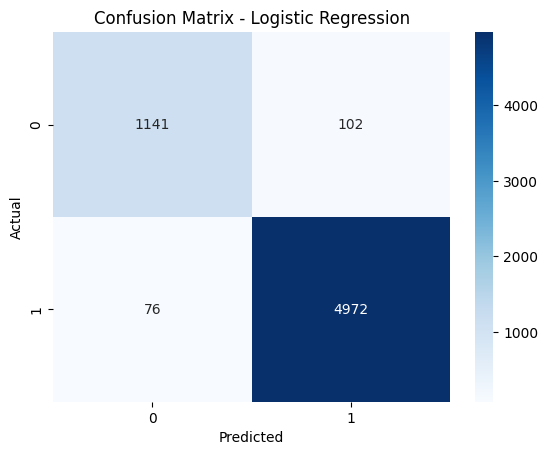

In [ ]:
# Evaluation
# Predict on test set
y_test_pred = lr_model.predict(X_test)

# Evaluate on test set
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

# Optional: confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Dictionary to store models and results
models = {}

# -----------------------
#Support Vector Machine (SVM)
# -----------------------
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

y_val_pred_svm = svm_model.predict(X_val)
print("SVM Validation Accuracy:", accuracy_score(y_val, y_val_pred_svm))
print(classification_report(y_val, y_val_pred_svm))

models['SVM'] = svm_model

# -----------------------
#Random Forest
# -----------------------
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_val_pred_rf = rf_model.predict(X_val)
print("Random Forest Validation Accuracy:", accuracy_score(y_val, y_val_pred_rf))
print(classification_report(y_val, y_val_pred_rf))

models['RandomForest'] = rf_model

# -----------------------
#XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

y_val_pred_xgb = xgb_model.predict(X_val)
print("XGBoost Validation Accuracy:", accuracy_score(y_val, y_val_pred_xgb))
print(classification_report(y_val, y_val_pred_xgb))

models['XGBoost'] = xgb_model

SVM Validation Accuracy: 0.9767922428866634
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1238
           1       0.99      0.98      0.99      5053

    accuracy                           0.98      6291
   macro avg       0.96      0.97      0.96      6291
weighted avg       0.98      0.98      0.98      6291

Random Forest Validation Accuracy: 0.9834684469877603
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1238
           1       0.99      0.99      0.99      5053

    accuracy                           0.98      6291
   macro avg       0.98      0.97      0.97      6291
weighted avg       0.98      0.98      0.98      6291



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:57:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Validation Accuracy: 0.979653473215705
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1238
           1       0.99      0.98      0.99      5053

    accuracy                           0.98      6291
   macro avg       0.96      0.98      0.97      6291
weighted avg       0.98      0.98      0.98      6291




--- Evaluation on Test Set: SVM ---
Accuracy Score: 0.979653473215705

Detailed Classification Results:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1243
           1       0.99      0.98      0.99      5048

    accuracy                           0.98      6291
   macro avg       0.96      0.97      0.97      6291
weighted avg       0.98      0.98      0.98      6291



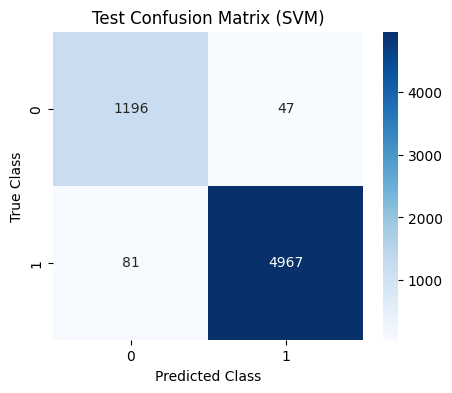


--- Evaluation on Test Set: RandomForest ---
Accuracy Score: 0.9864886345573041

Detailed Classification Results:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1243
           1       0.99      0.99      0.99      5048

    accuracy                           0.99      6291
   macro avg       0.98      0.98      0.98      6291
weighted avg       0.99      0.99      0.99      6291



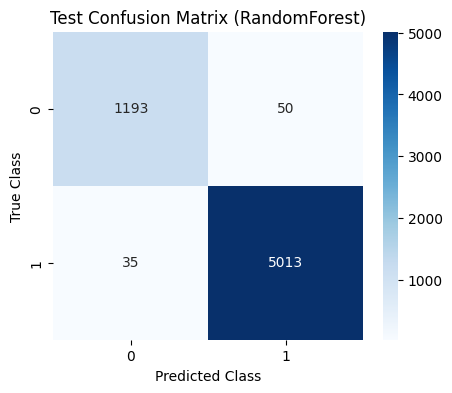


--- Evaluation on Test Set: XGBoost ---
Accuracy Score: 0.9806072166587187

Detailed Classification Results:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1243
           1       0.99      0.98      0.99      5048

    accuracy                           0.98      6291
   macro avg       0.96      0.98      0.97      6291
weighted avg       0.98      0.98      0.98      6291



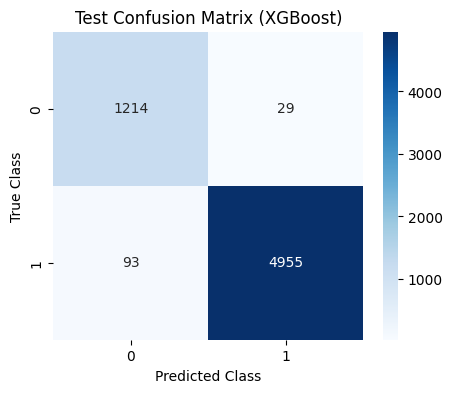

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

models_list = ['SVM', 'RandomForest', 'XGBoost']

for model_name in models_list:

    current_model = models[model_name]
    test_predictions = current_model.predict(X_test)

    print(f"\n--- Evaluation on Test Set: {model_name} ---")
    print("Accuracy Score:", accuracy_score(y_test, test_predictions))
    print("\nDetailed Classification Results:")
    print(classification_report(y_test, test_predictions))

    matrix = confusion_matrix(y_test, test_predictions)

    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Test Confusion Matrix ({model_name})')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()


In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

embedding_model = SentenceTransformer(
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)

train_texts = train_df["clean_text"].tolist()
val_texts   = val_df["clean_text"].tolist()
test_texts  = test_df["clean_text"].tolist()

X_train_emb = embedding_model.encode(train_texts, convert_to_numpy=True)
X_val_emb   = embedding_model.encode(val_texts, convert_to_numpy=True)
X_test_emb  = embedding_model.encode(test_texts, convert_to_numpy=True)

y_train = train_df["label"].to_numpy()
y_val   = val_df["label"].to_numpy()
y_test  = test_df["label"].to_numpy()

print("Training embeddings shape:", X_train_emb.shape)


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Training embeddings shape: (29358, 384)


In [ ]:
from tensorflow.keras import models, layers

classifier = models.Sequential()

classifier.add(layers.InputLayer(input_shape=(X_train_emb.shape[1],)))
classifier.add(layers.Dense(256, activation="relu"))
classifier.add(layers.Dropout(0.3))
classifier.add(layers.Dense(128, activation="relu"))
classifier.add(layers.Dropout(0.3))
classifier.add(layers.Dense(1, activation="sigmoid"))  # Binary classification output

classifier.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

classifier.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,585 (514.00 KB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
training_history = classifier.fit(
    X_train_emb,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_emb, y_val)
)


Epoch 1/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7963 - loss: 0.4516 - val_accuracy: 0.8449 - val_loss: 0.3671
Epoch 2/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8273 - loss: 0.3811 - val_accuracy: 0.8531 - val_loss: 0.3362
Epoch 3/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8363 - loss: 0.3621 - val_accuracy: 0.8530 - val_loss: 0.3372
Epoch 4/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8414 - loss: 0.3521 - val_accuracy: 0.8600 - val_loss: 0.3151
Epoch 5/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8471 - loss: 0.3362 - val_accuracy: 0.8558 - val_loss: 0.3134
Epoch 6/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8571 - loss: 0.3181 - val_accuracy: 0.8573 - val_loss: 0.3208
Epoch 7/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8546 - loss: 0.3177 - val_accuracy: 0.8679 - val_loss: 0.2995
Epoch 8/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8602 - loss: 0.3023 - val_accuracy: 0.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Generate predictions on the test set
test_probs = classifier.predict(X_test_emb)
test_preds = (test_probs >= 0.5).astype(int)

print("Test Set Accuracy:", accuracy_score(y_test, test_preds))
print("\nClassification Results:")
print(classification_report(y_test, test_preds))


197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Set Accuracy: 0.8658400890160547

Classification Results:
              precision    recall  f1-score   support

           0       0.76      0.47      0.58      1243
           1       0.88      0.96      0.92      5048

    accuracy                           0.87      6291
   macro avg       0.82      0.71      0.75      6291
weighted avg       0.86      0.87      0.85      6291



In [ ]:
import os
import joblib
from tensorflow.keras.models import Model as KerasModel

def persist_models(model_collection, output_path="models"):

    os.makedirs(output_path, exist_ok=True)

    for key, mdl in model_collection.items():

        if isinstance(mdl, KerasModel):
            save_path = os.path.join(output_path, f"{key}.h5")
            mdl.save(save_path)
            print(f"[Saved] Neural model → {save_path}")

        else:
            save_path = os.path.join(output_path, f"{key}.pkl")
            joblib.dump(mdl, save_path)
            print(f"[Saved] ML model → {save_path}")

    print("\nAll models have been stored successfully!")


In [ ]:
import os

os.makedirs("models", exist_ok=True)

models_dict = {
    "lr_model": lr_model,
    "svm": svm_model,
    "random_forest": rf_model,
    "xgboost": xgb_model,
    "ffnn": classifier
}

persist_models(models_dict)


[Saved] ML model → models/lr_model.pkl
[Saved] ML model → models/svm.pkl


[Saved] ML model → models/random_forest.pkl
[Saved] ML model → models/xgboost.pkl
[Saved] Neural model → models/ffnn.h5

All models have been stored successfully!
